# Discrete Task:
- Load data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from helper_functions.discrete_helper_functions import *
from helper_functions.comparison_helper_functions import *

# Load the datasets from the saved numpy arrays in the Familiarization task
X = np.load('./data/train_data.npy')
y = np.load('./data/actual_train_labels.npy')

X_test = np.load('./data/test_data.npy')

train_data = pd.read_pickle('./data/train_data_df.pkl')

# Seperate the two training datasets
# X1, y1 = training data and labels 1 (normal behaviour)
# X2, y2 = training data and labels 2 (attacks present)
num = 8761
X1 = X[:num]
X2 = X[num:]
y1 = y[:num]
y2 = y[num:]

ss = StandardScaler()
X1_scaled = ss.fit_transform(X1)
X2_scaled = ss.fit_transform(X2)

# Check that everything is there
print("Training dataset shape: ", X.shape)
print("Test dataset shape: ", X_test.shape)
print("Number of attacks: ", np.sum(y==1))

Training dataset shape:  (12938, 40)
Test dataset shape:  (2089, 40)
Number of attacks:  492


## Discrete Methods

#### Sybmolic Aggregate Approximation

[[[0]
  [0]
  [1]
  [2]
  [2]
  [2]
  [2]
  [1]]]


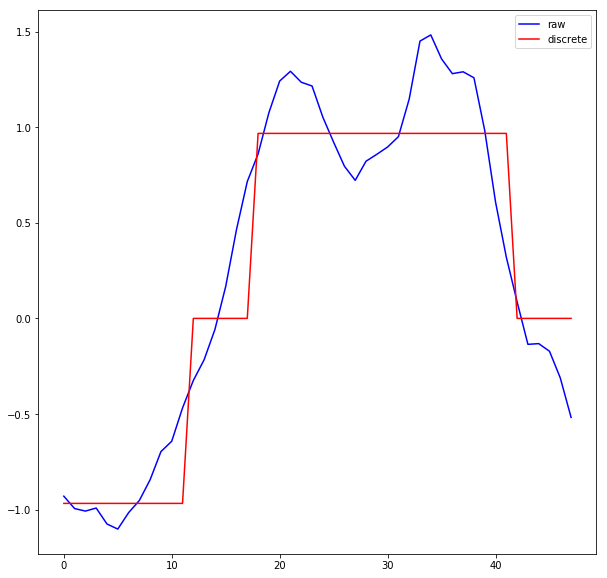

In [2]:
from tslearn.piecewise import SymbolicAggregateApproximation

offset = 10
window_size = 48
raw_data = X1_scaled[offset: offset+window_size, 0]

n_sax_symbols = 3
sax = SymbolicAggregateApproximation(n_segments=8, alphabet_size_avg=n_sax_symbols)
sax_dataset = sax.fit_transform(raw_data)
sax_dataset_inv = sax.inverse_transform(sax_dataset)

print(sax_dataset)
# print(sax_dataset_inv)
plt.figure(figsize = (10,10))
plt.plot(raw_data, color = 'b', label = 'raw')
plt.plot(sax_dataset_inv[0], color = 'r', label = 'discrete')
plt.legend()

In [30]:
# Discretise train and test signal
train_sax=sax_via_window(X1[:, 0], 48, 8, alphabet_size=3,
               nr_strategy='none', z_threshold=0.01)
test_sax = sax_via_window(X2[:,0], 48, 8, alphabet_size=3,
                         nr_strategy='none')

In [28]:
signal = X1_scaled[:, 0]
window_size = 40
paa_segments = 8
alphabet_size = 3

def discretize(raw_signal, window_size, paa_segments, alphabet_size):
    sax = SymbolicAggregateApproximation(n_segments=paa_segments, alphabet_size_avg=alphabet_size)
    discrete_signal = []
    num = len(signal)//window_size
    
    for i in range(num):
        raw = raw_signal[i*window_size : (i+1)*window_size]
        disc = sax.inverse_transform(sax.fit_transform(raw_data))
        discrete_signal.append(np.squeeze(disc))
    discrete_signal = [x for sublist in discrete_signal for x in sublist]
    
    return discrete_signal

discrete_signal = discretize(signal, window_size, paa_segments, alphabet_size)

NameError: name 'SymbolicAggregateApproximation' is not defined

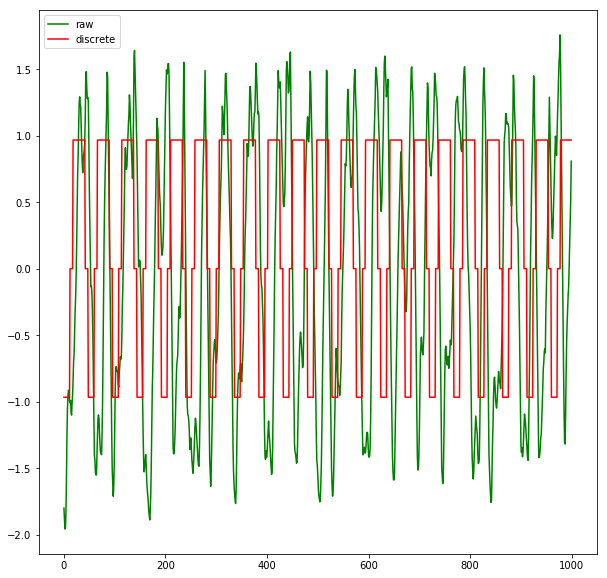

In [5]:
plt.figure(figsize=(10,10))
plt.plot(signal[:1000], color='g', label = 'raw')
plt.plot(discrete_signal[:1000], color='r', label = 'discrete')
plt.legend()

In [6]:
def discretizeV2(raw_signal, window_size, paa_segments):
    discrete_signal = []
    num = window_size//paa_segments

    for i in range(0, len(signal), window_size):
        for ngram in list(train_sax.keys()):
            if i in train_sax[ngram]:
                for n in range(8):
                    discrete_signal.append(np.tile(ngram[n], num))

    discrete_signal = [x for sublist in discrete_signal for x in sublist]
    return discrete_signal

discrete_signal = discretizeV2(signal, window_size, paa_segments)

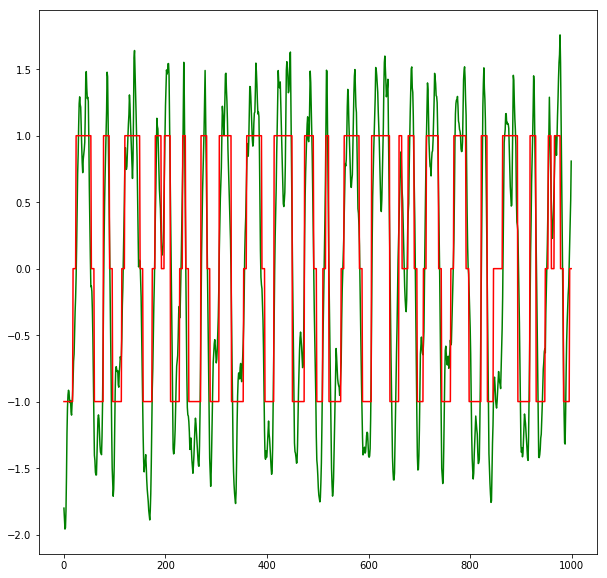

In [8]:
enum = {'a':-1, 'b': 0, 'c':1}
disc_enum = [enum[x] for x in discrete_signal]

plt.figure(figsize=(10,10))
plt.plot(signal[:1000], color='g', label='raw')
plt.plot(disc_enum[:1000], color='r', label='discrete')

In [31]:
# Extract ngram probabilities and training profile based on most frequent ngrams
train_probs = extract_ngram_probs(train_sax)

labels = np.array(y2, copy=True)

train_prof = extract_train_prof(train_probs, thres=1)

# raise an alarm for encountered ngrams in the test signal, not present in the 
# training profile
alarm_regions = extract_alarm_regions(test_sax, train_prof)

In [32]:
# Compute score S
gamma=0.5

predicted_labels = np.zeros_like(labels)
predicted_labels[alarm_regions] = 1

sttd = compute_sttd(labels, predicted_labels)
cm = estimate_confusion_matrix(labels, predicted_labels)
scm = compute_scm(cm)
s = compute_s(labels, predicted_labels,gamma)

print(cm.shape)
print(sttd, scm)
print(s)

(2, 2)
0.21124620060790278 0.5527625177880001
0.38200435919795145


In [39]:
((63/(63+429)) + (3602/(3602+83)))/2

0.5527625177880001

Confusion matrix:  [[  63   83]
 [ 429 3602]]


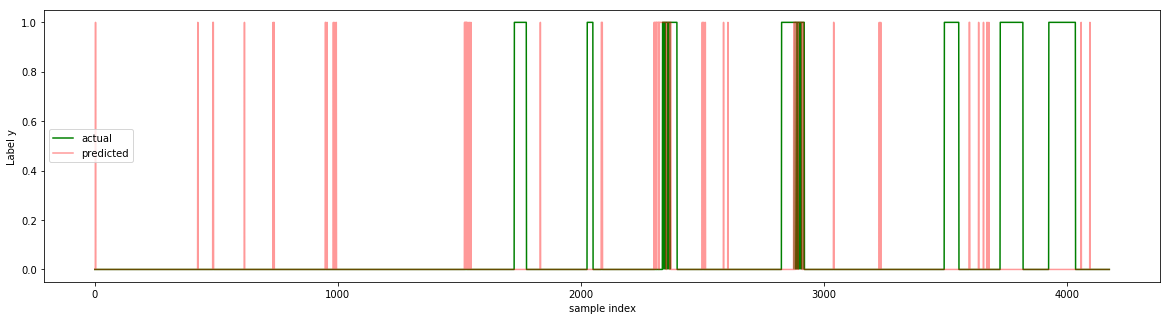

In [35]:
cm = estimate_confusion_matrix(labels, predicted_labels)
print("Confusion matrix: ", cm)
plot(labels, predicted_labels)

In [13]:
window_size = np.array([2, 5, 10, 25, 50, 100, 200])
vocab_size = np.arange(3, 6, dtype=int)
paa_segments = np.array([2,4,8,16,32,64])

signal = X1[:, 0]
test_signal = X2[:, 0]
test_labels = np.array(y2, copy=True)

TP = np.zeros((len(window_size), len(paa_segments), len(vocab_size), len(L)), dtype=int)
FP = np.zeros_like(TP)
S = np.zeros((len(window_size), len(paa_segments), len(vocab_size), len(L)))
for w in range(len(window_size)):
    for p in range(len(paa_segments)):
        for v in range(len(vocab_size)):
            train_sax=sax_via_window(signal, window_size[w], paa_segments[p], vocab_size[v],
               nr_strategy='none', z_threshold=0.01)
            test_sax = sax_via_window(test_signal, window_size[w], paa_segments[p], vocab_size[v],
                         nr_strategy='none')

            train_probs = extract_ngram_probs(train_sax)
            train_prof = extract_train_prof(train_probs, thres=1)
            alarm_regions = extract_alarm_regions(test_sax, train_prof)
            print("Attacks detected: ", len(alarm_regions))
            if not alarm_regions:
                continue


            predicted_labels = np.zeros_like(test_labels)
            predicted_labels[alarm_regions] = 1
            cm = estimate_confusion_matrix(test_labels, predicted_labels)
            print("CM: ", cm)
            TP[w, p, v, l] = cm[0,0]
            FP[w, p, v, l] = cm[0,1]
            s = compute_s(test_labels, predicted_labels, 0.5)
            S[w,p,v,l] = s
            
            

Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0
Attacks detected:  0


KeyboardInterrupt: 

In [13]:
def optimal_parameters(train_signal, train_labels, test_signal, test_labels, window_size, paa_segments, vocab_size, gamma):
    S = np.zeros((len(window_size), len(paa_segments), len(vocab_size)))
    
    max_S = 0
    optimal_labels = np.zeros_like(test_labels)
    
    for w in range(len(window_size)):
        for p in range(len(paa_segments)):
            for v in range(len(vocab_size)):
                train_sax=sax_via_window(train_signal, window_size[w], paa_segments[p], vocab_size[v],
                   nr_strategy='none', z_threshold=0.01)
                test_sax = sax_via_window(test_signal, window_size[w], paa_segments[p], vocab_size[v],
                             nr_strategy='none')

                train_probs = extract_ngram_probs(train_sax)
                train_prof = extract_train_prof(train_probs, thres=1)
                alarm_regions = extract_alarm_regions(test_sax, train_prof)

#                 print("Attacks detected: ", len(alarm_regions))
                if not alarm_regions:
                    continue

                predicted_labels = np.zeros_like(test_labels)
                predicted_labels[alarm_regions] = 1

                s = compute_s(test_labels, predicted_labels, gamma)
                if s > max_S:
                    optimal_labels = predicted_labels
                S[w,p,v] = s
                    
        return S, optimal_labels
                    

In [40]:
train_signal = X1[:, 0]
train_labels = np.array(y1, copy=True)
test_signal = X2[:, 0]
test_labels = np.array(y2, copy=True)

window_size = np.array([5, 10, 20, 40, 50, 100, 200])
paa_segments = np.array([4, 8, 16, 32], dtype=int)
vocab_size = np.arange(3, 7, dtype=int)


S, optimal_labels = optimal_parameters(train_signal, train_labels, test_signal, test_labels,
                                              window_size, paa_segments, vocab_size, 0.01)

In [41]:
print("Max S: ", np.max(S))
ind = np.unravel_index(np.argmax(S), S.shape)
print(ind)



Max S:  0.5390287858636443
(0, 1, 3)


[[  60  211]
 [ 432 3474]]


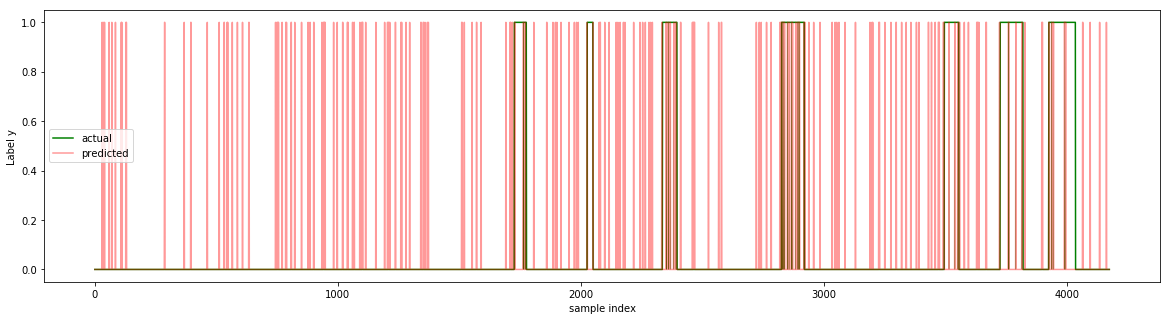

In [27]:
plot(test_labels, optimal_labels)
cm = estimate_confusion_matrix(test_labels, optimal_labels)
print(cm)